# In this notebook I'll be forcasting the daily climate in the city of Delhi, India. 

In [20]:
# importing libraries.
import numpy as np 
import pandas as pd 


In [21]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
from plotly.subplots import make_subplots
import plotly.graph_objs as go

In [22]:
# Reading the data.
train = pd.read_csv('/kaggle/input/climate-data/DailyDelhiClimateTrain.csv')
test = pd.read_csv('/kaggle/input/climate-data/DailyDelhiClimateTest.csv')

In [23]:
# Showing a sample of train data.
train.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.22,68.04,3.55,1015.57
1458,2016-12-29,15.24,87.86,6.00,1016.90
1459,2016-12-30,14.10,89.67,6.27,1017.90
1460,2016-12-31,15.05,87.00,7.33,1016.10
1461,2017-01-01,10.00,100.00,0.00,1016.00


In [24]:
# Showing a sample of test data.
test = test.iloc[1:,:]
test.head()

,date,meantemp,humidity,wind_speed,meanpressure
1,2017-01-02,18.50,77.22,2.89,1018.28
2,2017-01-03,17.11,81.89,4.02,1018.33
3,2017-01-04,18.70,70.05,4.54,1015.70
4,2017-01-05,18.39,74.94,3.30,1014.33
5,2017-01-06,19.32,79.32,8.68,1011.77


## Now before preprocessing the data let's merge it up and give it the right formats. 

In [25]:
full_data = pd.concat((test, train), ignore_index=True) # merging the data.
full_data['date'] = pd.to_datetime(full_data['date']) # making the data in datetime format.
full_data = full_data.sort_values(by=['date']) # sorting by date.

## Now let's take a look of how the data behaved through the years!

In [26]:
# plotting the data.
fig = make_subplots(rows=4, cols=1,
                    vertical_spacing=0.1,
                    subplot_titles=('meantemp', 'humidity',
                                    "wind_speed" ,'meanpressure'))

fig.append_trace(go.Scatter(x=full_data['date'], y=full_data['meantemp']),
              row=1, col=1)

fig.add_trace(go.Scatter(x=full_data['date'], y=full_data['humidity']),
              row=2, col=1)

fig.add_trace(go.Scatter(x=full_data['date'], y=full_data['wind_speed']),
              row=3, col=1)

fig.add_trace(go.Scatter(x=full_data['date'], y=full_data['meanpressure']),
              row=4, col=1)

fig.update_layout(height=1600,showlegend=False)
fig.show()


## Making the data ready for modeling.

In [27]:
# creating a function that removes outliers statisticaly. 
def remove_outliers(column):
    Q1 = column.quantile(.25)
    Q3 = column.quantile(.75)
    IQR = Q3 - Q1
    column = column[((Q1 - 1.5 * IQR) <= column) & (column  <= (Q3 + 1.5 * IQR))]
    return column

In [28]:
full_data['year'] = full_data.date.dt.year # making year column.
full_data['month'] = full_data.date.dt.month # making month column.
full_data['monthday'] = full_data.date.dt.day # making day of month column.
full_data['yearday'] = full_data.date.dt.dayofyear # making day of year column.
full_data.rename(columns={'date':'ds'},inplace=True) # changing the date column name to "ds" for NeuralProphet model.
for col in ["wind_speed" ,'meanpressure']:  
    full_data[col] = remove_outliers(full_data[col]) # removing the column's outliers
full_data.dropna(inplace=True)
# spliting the data back to train and test data.
train = full_data.iloc[:len(train),:]
test = full_data.iloc[len(train):,:] 

In [29]:
# plotting the data.
fig = make_subplots(rows=2, cols=1,
                    vertical_spacing=0.1,
                    subplot_titles=("wind_speed" ,'meanpressure'))

fig.add_trace(go.Scatter(x=full_data['ds'], y=full_data['wind_speed']),
              row=1, col=1)

fig.add_trace(go.Scatter(x=full_data['ds'], y=full_data['meanpressure']),
              row=2, col=1)

fig.update_layout(height=800,showlegend=False)
fig.show()


## Now it's modeling time, first let's use KNeighbors algorithm to try to predict all the test data only by it's date data.

In [30]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

KNNforecasts = dict()

for column in ['meantemp','humidity','wind_speed','meanpressure']:
    
    m = KNeighborsRegressor(n_neighbors=27)
    X = train[['year','month','monthday','yearday']]
    y = train[column]
    model = m.fit(X,y)
    X_test = test[['year','month','monthday','yearday']]
    forecast = m.predict(X_test)
    KNNforecasts[column] = forecast
    print(f'r2 score for {column} : {r2_score(test[column],forecast)}')

r2 score for meantemp : 0.7557786335358677
r2 score for humidity : 0.0746261106241789
r2 score for wind_speed : -0.05429570665842798
r2 score for meanpressure : 0.4315210698036458


In [31]:
m = KNeighborsRegressor(n_neighbors=27)
X = train[['year','month','monthday','yearday']]
y = train['meantemp']
model = m.fit(X,y)
X_test = test[['year','month','monthday','yearday']]
forecast = m.predict(X_test)
KNNforecasts['meantemp'] = forecast


In [32]:
X_test

,year,month,monthday,yearday
41,2017,2,12,43
42,2017,2,13,44
43,2017,2,14,45
44,2017,2,15,46
45,2017,2,16,47
46,2017,2,17,48
47,2017,2,18,49
48,2017,2,19,50
49,2017,2,20,51
50,2017,2,21,52


In [33]:
pip install dynamask

Note: you may need to restart the kernel to use updated packages.


In [34]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('GPU')
else:
    device = torch.device('cpu')
    print('CPU')


CPU


In [35]:
from dynamask.fit.TSX.utils import load_data
import torch
import torch.utils.data as utils
from torch.utils.data import DataLoader
from dynamask.attribution.perturbation import FadeMovingAverage
from  dynamask.attribution.perturbation import GaussianBlur
from torch.nn.functional import mse_loss
from dynamask.attribution.mask import Mask
#from dynamask.models.models import StateClassifier
from dynamask.attribution.mask_group import MaskGroup

In [36]:
def blackbox(x):
    out=model.predict(x.detach().cpu().numpy())
    return torch.tensor(out)

In [37]:
pert = GaussianBlur(device)
mask = MaskGroup(pert, device)

In [38]:
X_test

,year,month,monthday,yearday
41,2017,2,12,43
42,2017,2,13,44
43,2017,2,14,45
44,2017,2,15,46
45,2017,2,16,47
46,2017,2,17,48
47,2017,2,18,49
48,2017,2,19,50
49,2017,2,20,51
50,2017,2,21,52


In [42]:
areas = [0.1, .25,0.35,0.45,0.55,0.65,0.66,0.70,0.80]
mask.fit(torch.tensor(X_test.values, dtype=torch.float), f=blackbox, loss_function=mse_loss, size_reg_factor_init=0.01,area_list=areas,learning_rate=2.5, size_reg_factor_dilation=10000, initial_mask_coeff=0.5, n_epoch=2000, momentum=1.0, time_reg_factor=2)

Epoch 1/2000: error = 0.00569 ; size regulator = 0.25 ; time regulator = 0 ; time elapsed = 0.0826 s
Epoch 2/2000: error = 0.00564 ; size regulator = 0.25 ; time regulator = 1.13e-06 ; time elapsed = 0.0198 s
Epoch 3/2000: error = 0.00522 ; size regulator = 0.25 ; time regulator = 0.000447 ; time elapsed = 0.0173 s
Epoch 4/2000: error = 0.00444 ; size regulator = 0.25 ; time regulator = 0.000415 ; time elapsed = 0.0143 s
Epoch 5/2000: error = 0.0053 ; size regulator = 0.25 ; time regulator = 0.000694 ; time elapsed = 0.0135 s
Epoch 6/2000: error = 0.00526 ; size regulator = 0.25 ; time regulator = 0.000699 ; time elapsed = 0.267 s
Epoch 7/2000: error = 0.00526 ; size regulator = 0.249 ; time regulator = 0.00104 ; time elapsed = 0.0151 s
Epoch 8/2000: error = 0.00525 ; size regulator = 0.249 ; time regulator = 0.0011 ; time elapsed = 0.0142 s
Epoch 9/2000: error = 0.00572 ; size regulator = 0.249 ; time regulator = 0.00123 ; time elapsed = 0.014 s
Epoch 10/2000: error = 0.00494 ; size r

The mask of area 0.1 is extremal with error = 0.00832.


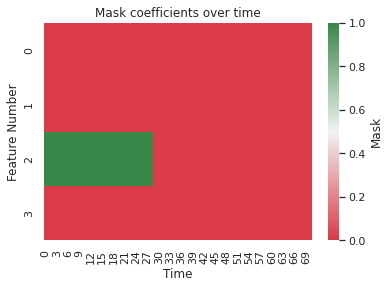

In [43]:
masks = mask.get_extremal_mask(threshold=0.3)
masks.plot_mask(smooth= False, sigma=2.0)